<a href="https://colab.research.google.com/github/Sruthi-Shivaram/Ml_Minor/blob/main/ML_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Experiment No 3: Machine learning Minor
Decison tree Build up and comparison with KNN
Try to run following code and follow up the exercise given below.

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


It took 0.8170367869999922 seconds to complete the shading with a DT
It took 10.503035982 seconds to complete the shading with kNN
DTs get faster compared to kNN as number of training points increases - set n = 500 and see


<string>:6: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:993: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(value)


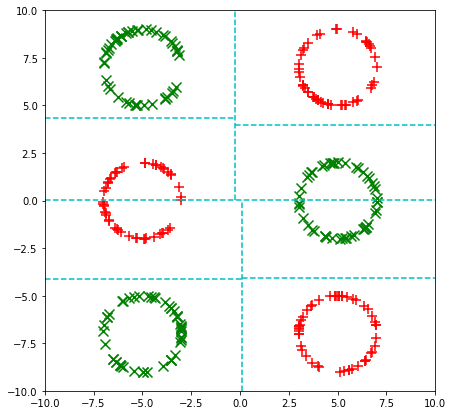

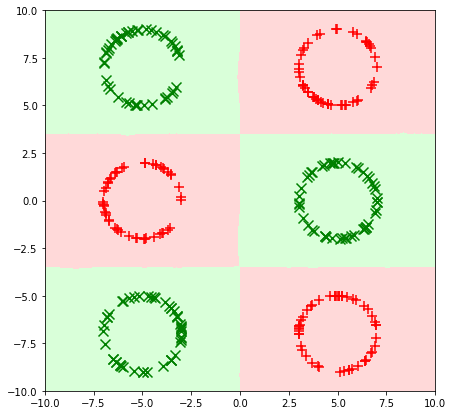

In [ ]:
import numpy as np
from numpy import linalg as lin
import genSyntheticData as gsd
import plotData as pd
from matplotlib import pyplot as plt
import time as t

class Node:
    # A node stores its own depth (root = depth 0), its decision stump, its parent and child information
    # Leaf nodes also store a constant label that is assigned to every data point that reaches that leaf
    def __init__( self, depth = 0, stump = (0,0), parent = None ):
        self.depth = depth
        self.stump = stump
        self.parent = parent
        self.left = None
        self.right = None
        self.isLeaf = True
        self.label = 0
        
    def predict( self, data ):
        # If I am a leaf I can predict rightaway
        # May change this constant leaf action to something more interesting and powerful
        if self.isLeaf:
            return self.label
        # Else I have to ask one of my children to do the job
        else:
            if data[self.stump[0]] > self.stump[1]:
                return self.right.predict( data )
            else:
                return self.left.predict( data )
            
    # Get the Gini coefficient of a node with nPos positive points and nNeg negative points
    def getGini( self, nPos, nNeg ):
        nTot = nPos + nNeg
        # Find the proportion of the positives and negatives in that node
        pPos = nPos/nTot
        pNeg = nNeg/nTot
        # The gini index is always a real number between 0 and 0.5
        # A perfectly pure node has gini index = 0
        # The smaller the gini index the purer the node
        gini = 1 - (pPos**2 + pNeg**2)
        return gini
            
    def getStump( self, X, y ):
        # How many data points do I have at this node?
        n = y.size
        bestObjective = float('inf')
        
        # For each of the features in the data
        for i in range( X.shape[1] ):
            # Do not use the same feature as used by the parent node
            if self.parent is not None and i == self.parent.stump[0]:
                continue
            # Find out all values at which we can threshold that feature
            candidateThresholds = np.sort( X[:, i] )
            idx = np.argsort( X[:, i] )
            # The cumulative sum trick used here will work only if labels are binary 
            ySorted = y[idx]
            yCum = np.cumsum( ySorted )
            yCumRev = np.cumsum( ySorted[::-1] )[::-1]
            # For each possible threshold (except the ones at the extreme)
            for j in range( 1, candidateThresholds.size-1 ):
                # Give 0.5 weight to balance and 1 weight to purity of the two nodes
                candidateObjective = 0.0 * 0.0 \
                                    + 1.0 * self.getGini( (yCum[j] + j+1)/2, (j+1 - yCum[j])/2 ) \
                                    + 1.0 * self.getGini( (yCumRev[j+1] + n-j-1)/2, (n-j-1 - yCumRev[j+1])/2 )
                if candidateObjective < bestObjective:
                    bestObjective = candidateObjective
                    bestFeat = i
                    bestThresh = candidateThresholds[j]
        
        # Can try LwP decision stump as well
        bestThresh = (np.mean(X[y > 0, bestFeat]) + np.mean(X[y < 0, bestFeat]))/2
        return (bestFeat, bestThresh)
            
    def train( self, X, y, maxLeafSize, maxDepth ):
        # If too few data points are present, or else if this node is too deep in the tree, make this a leaf
        if y.size < maxLeafSize or self.depth >= maxDepth:
            self.isLeaf = True
            self.label = np.mean( y )
        else:
            # This node will be split and hence it is not a leaf
            self.isLeaf = False
            # Get the best possible decision stump
            self.stump = self.getStump( X, y )
            self.left = Node( depth = self.depth + 1, parent = self )
            self.right = Node( depth = self.depth + 1, parent = self )
            # Find which points go to my left child and which go to my right child
            discriminant = X[:, self.stump[0]] - self.stump[1]
            # Train my two children recursively
            self.left.train( X[discriminant <= 0, :], y[discriminant <= 0], maxLeafSize, maxDepth )
            self.right.train( X[discriminant > 0, :], y[discriminant > 0], maxLeafSize, maxDepth )

class Tree:
    def __init__( self, maxLeafSize = 10, maxDepth = 5 ):
        self.root = Node()
        self.maxLeafSize = maxLeafSize
        self.maxDepth = maxDepth 
        
    def predict( self, xt, yt ):
        return self.root.predict( np.array( [xt, yt] ) )
    
    def train( self, X, y ):
        self.root.train( X, y, self.maxLeafSize, self.maxDepth )

d = 2 
n = 50
r = 2

tmp1 = gsd.genSphericalData( d, n, [-5, -7], r )
tmp2 = gsd.genSphericalData( d, n, [5, 0], r )
tmp3 = gsd.genSphericalData( d, n, [-5, 7], r )
XPos = np.vstack( (tmp1, tmp2, tmp3) )
yPos = np.ones( (3*n,) )

tmp1 = gsd.genSphericalData( d, n, [5, -7], r )
tmp2 = gsd.genSphericalData( d, n, [-5, 0], r )
tmp3 = gsd.genSphericalData( d, n, [5, 7], r )
XNeg = np.vstack( (tmp1, tmp2, tmp3) )
yNeg = -np.ones( (3*n,) )

X = np.vstack( (XPos, XNeg) )
y = np.concatenate( (yPos, yNeg) )

DT = Tree( maxLeafSize = 5, maxDepth = 4 )
DT.train( X, y )

def drawTreeSplits( node, fig, xlim, ylim ):
    if not node.isLeaf:
        plt.figure( fig.number )
        # Is this a vertical split or a horizontal one?
        if node.stump[0] == 0:
            plt.plot( [node.stump[1], node.stump[1]], ylim, color = 'c', linestyle = '--' )
            drawTreeSplits( node.left, fig, [xlim[0], node.stump[1]], ylim )
            drawTreeSplits( node.right, fig, [node.stump[1], xlim[1]], ylim )
        elif node.stump[0] == 1:
            plt.plot( xlim, [node.stump[1], node.stump[1]], color = 'c', linestyle = '--' )
            drawTreeSplits( node.left, fig, xlim, [ylim[0], node.stump[1]] )
            drawTreeSplits( node.right, fig, xlim, [node.stump[1], ylim[1]] )
            
def kNNClass( xt, yt ):
    diff = X - np.array( [xt, yt] )
    dist = lin.norm( diff, axis = 1 )
    idx = np.argsort( dist )
    yhat = 0
    wsum = 0
    for i in range( k ):
        yhat = yhat + y[idx[i]]
    return yhat/k

fig = pd.getFigure()
tic = t.process_time()
pd.shade2D( DT.predict, fig, mode = 'point', xlim = 10, ylim = 10, nBins = 500 )
toc = t.process_time()
print( "It took " + str(toc - tic) + " seconds to complete the shading with a DT")
drawTreeSplits(DT.root, fig, xlim = [-10, 10],  ylim = [-10, 10])
pd.plot2D( XNeg, fig, color = 'r', marker = '+' )
pd.plot2D( XPos, fig, color = 'g', marker = 'x' )

k = 1
fig2 = pd.getFigure()
tic = t.process_time()
pd.shade2D( kNNClass, fig2, mode = 'point', xlim = 10, ylim = 10, nBins = 500 )
toc = t.process_time()
print( "It took " + str(toc - tic) + " seconds to complete the shading with kNN")
pd.plot2D( XNeg, fig2, color = 'r', marker = '+' )
pd.plot2D( XPos, fig2, color = 'g', marker = 'x' )
print( "DTs get faster compared to kNN as number of training points increases - set n = 500 and see" )

## Problem

1. Can you change the DT to use information gain instead of Gini impurity for the criterion split
2. Can you use the DT learning code given here to train a DT with this dataset ([link](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29))?
3. Experiment with the tree hyperparameters using cross-validation to see what sort of tree works best for this dataset.

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [ ]:
data=pd.read_csv('/content/breast-cancer-wisconsin.csv')
data.head()

,Sample code number,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


In [ ]:
data.describe()

,Sample code number,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bland Chromatin,Normal Nucleoli,Mitoses,Class
count,6.990000e+02,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000
mean,1.071704e+06,4.417740,3.134478,3.207439,2.806867,3.216023,3.437768,2.866953,1.589413,2.689557
std,6.170957e+05,2.815741,3.051459,2.971913,2.855379,2.214300,2.438364,3.053634,1.715078,0.951273
min,6.163400e+04,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000
25%,8.706885e+05,2.000000,1.000000,1.000000,1.000000,2.000000,2.000000,1.000000,1.000000,2.000000
50%,1.171710e+06,4.000000,1.000000,1.000000,1.000000,2.000000,3.000000,1.000000,1.000000,2.000000
75%,1.238298e+06,6.000000,5.000000,5.000000,4.000000,4.000000,5.000000,4.000000,1.000000,4.000000
max,1.345435e+07,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,4.000000


In [ ]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Sample code number           699 non-null    int64 
 1   Clump Thickness              699 non-null    int64 
 2   Uniformity of Cell Size      699 non-null    int64 
 3   Uniformity of Cell Shape     699 non-null    int64 
 4   Marginal Adhesion            699 non-null    int64 
 5   Single Epithelial Cell Size  699 non-null    int64 
 6   Bare Nuclei                  699 non-null    object
 7   Bland Chromatin              699 non-null    int64 
 8   Normal Nucleoli              699 non-null    int64 
 9   Mitoses                      699 non-null    int64 
 10  Class                        699 non-null    int64 
dtypes: int64(10), object(1)
memory usage: 60.2+ KB


In [ ]:
columns=data.columns
columns=columns[1:-1]
print(columns)

Index(['Clump Thickness', 'Uniformity of Cell Size',
       'Uniformity of Cell Shape ', 'Marginal Adhesion',
       'Single Epithelial Cell Size', 'Bare Nuclei', 'Bland Chromatin',
       'Normal Nucleoli', 'Mitoses'],
      dtype='object')


In [ ]:
data.isnull().sum()

Sample code number             0
Clump Thickness                0
Uniformity of Cell Size        0
Uniformity of Cell Shape       0
Marginal Adhesion              0
Single Epithelial Cell Size    0
Bare Nuclei                    0
Bland Chromatin                0
Normal Nucleoli                0
Mitoses                        0
Class                          0
dtype: int64

In [ ]:
data['Clump Thickness']=data['Clump Thickness'].replace('?', 0)
data['Uniformity of Cell Size']=data['Uniformity of Cell Size'].replace('?', 0)
data['Uniformity of Cell Shape ']=data['Uniformity of Cell Shape '].replace('?', 0)
data['Marginal Adhesion']=data['Marginal Adhesion'].replace('?', 0)
data['Single Epithelial Cell Size']=data['Single Epithelial Cell Size'].replace('?', 0)
data['Bare Nuclei']=data['Bare Nuclei'].replace('?', 0)
data['Bland Chromatin']=data['Bland Chromatin'].replace('?', 0)
data['Normal Nucleoli']=data['Normal Nucleoli'].replace('?', 0)
data['Mitoses']=data['Mitoses'].replace('?', 0)
data['Class']=data['Class'].replace('?', 0)

In [ ]:
data

,Sample code number,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...
694,776715,3,1,1,1,3,2,1,1,1,2
695,841769,2,1,1,1,2,1,1,1,1,2
696,888820,5,10,10,3,7,3,8,10,2,4
697,897471,4,8,6,4,3,4,10,6,1,4


In [ ]:
data.isnull().sum()

Sample code number             0
Clump Thickness                0
Uniformity of Cell Size        0
Uniformity of Cell Shape       0
Marginal Adhesion              0
Single Epithelial Cell Size    0
Bare Nuclei                    0
Bland Chromatin                0
Normal Nucleoli                0
Mitoses                        0
Class                          0
dtype: int64

In [ ]:
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

In [ ]:
datavar = pd.DataFrame(data, columns=['Clump Thickness','Uniformity of Cell Size', 'Uniformity of Cell Shape ', 'Marginal Adhesion', 'Single Epithelial Cell Size','Bare Nuclei','Bland Chromatin','Normal Nucleoli','Mitoses'])
target=data['Class']

In [ ]:
X = datavar
y = target

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1) # 75% training and 25% test

In [ ]:
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

In [ ]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9428571428571428


In [ ]:
from sklearn.tree import DecisionTreeRegressor 
  
# create a regressor object
regressor = DecisionTreeRegressor(random_state = 0) 
  
# fit the regressor with X and Y data
regressor.fit(X, y)

DecisionTreeRegressor(random_state=0)

In [ ]:
y_pred = regressor.predict(X_test)

In [ ]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 1.0


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
df_classifier = DecisionTreeClassifier(random_state=999)

params_DT = {'criterion': ['gini', 'entropy'],
             'max_depth': [1, 2, 3, 4, 5, 6, 7, 8],
             'min_samples_split': [2, 3]}

gs_DT = GridSearchCV(estimator=df_classifier, 
                     param_grid=params_DT, 
                     cv=15,
                     verbose=1, 
                     scoring='accuracy')

gs_DT.fit(datavar, target);


Fitting 15 folds for each of 32 candidates, totalling 480 fits


In [ ]:
gs_DT.best_params_

{'criterion': 'gini', 'max_depth': 6, 'min_samples_split': 3}

In [ ]:
gs_DT.best_score_

0.9501387604070305

In [ ]:
results_DT = pd.DataFrame(gs_DT.cv_results_['params'])
results_DT['test_score'] = gs_DT.cv_results_['mean_test_score']
results_DT.columns


Index(['criterion', 'max_depth', 'min_samples_split', 'test_score'], dtype='object')

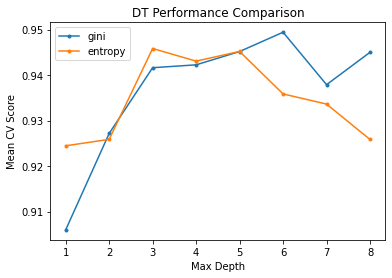

In [ ]:
for i in ['gini', 'entropy']:
    temp = results_DT[results_DT['criterion'] == i]
    temp_average = temp.groupby('max_depth').agg({'test_score': 'mean'})
    plt.plot(temp_average, marker = '.', label = i)
    
    
plt.legend()
plt.xlabel('Max Depth')
plt.ylabel("Mean CV Score")
plt.title("DT Performance Comparison")
plt.show()

In [ ]:
clf = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=6, min_samples_split=3, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, class_weight=None, ccp_alpha=0.0)

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

In [ ]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.96
